# Final Project


## Problem description

Time to show off everything you learned !

You will be performing a Classification task to analyze the sentiment of product reviews.

This is similar to a prior assignment
- With a different dataset
- Multinomial classification with 5 classes

But, by now, you have many more tools at your disposal.

## Some possible approaches
- A review is a sequence of words.  You will need to deal with sequences in some manner.  Some suggestions
  - Pooling
  - Recurrent Neural Network
- Is there an advantage to recognizing *adjacent* words groups ("n-grams") rather than treating the document as an unordered set of words ?
  - Consider these two sentences
    - "Machine Learning is easy not hard"
    - "Machine Learning is hard not easy"

  - Two sentences with identical words but different meaning.
  - Hint: Convolutional layer
- How should we encode words ?
  - OHE ? Embedding ?

We will **not specify** an approach.  Feel free to experiment.

Your goal is to produce a model with an out of sample accuracy meeting a minimum

Your goal is to produce a model with an out of sample accuracy meeting a minimum


  
# Advice 
- Your first model should be *simple* (e.g., OHE + GlobalMaxPooling + Logistic Regression)
    - Use it to study the data and get a feel for the problem
    - It establishes a baseline from which to improve
- Use Error Analysis to understand where your model is failing.
    - Perhaps the failure cases suggest improvements ?
- Remember: this is an *iterative* process
    - Your later models can become increasingly complex (e.g., Embedding + LSTM)

## Grading

Prior assignments evaluated you step by step.

This project is **results-based**. Your goal is to create a model
- That achieves an out of sample accuracy of at least 50%
- 60% would be better !

There are three data files in the directory `./resource/asnlib/publicdata/tweets/data`:  
- `train.csv`:
    - This is the dataset on which you will train your model
- `test.csv`:
    - This is the dataset by which you will be judged !
    - It has no labels so **you** can't use it to train or test your model
        - But **we do have** the labels so we can test your accuracy
    - Once you have built your model, you will make predictions on these examples and submit them for grading
- `submit_sample.csv`:
    - The file of predictions that you will submit should be similar in format to this file

**The file that you submit for grading**
- Should be named "my_submit.csv"
**Submit your file: save outputs of your model in a pandas dataframe, name it "my_submit.csv"**

## Learning objectives
- Experimentation !
- Error Analysis leading to model improvement
- Appreciate how choices impact number of weights


In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing

import os
import re
import json
import math

%matplotlib inline

import tensorflow as tf
print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )


from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, LSTM

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.utils import plot_model
import IPython

Running TensorFlow version  2.1.0
Version 2, minor 1


# API for students

We will define some utility routines.

This will simplify problem solving

More importantly: it adds structure to your submission so that it may be easily graded

**If you want to take a look at the API or change it, you can open it by selecting "File->Open->final_helper.py"**

`helper = final_helper.HELPER()`

### Preprocess raw dataset
- getDataRaw: get raw data.          
  >`train_raw, test_raw = helper.getDataRaw()`         
- getTextClean: clean text. 
  >`data_raw` is the raw data you get from `helper.getDataRaw()`, which is a pandas DataFrame          
  >`textAttr` is the column of text data      
  >`sentAttr` is the column of label       
  >`docs, sents = helepr.getTextClean(data_raw, textAttr, sentAttr`         
- encodeDocs: text tokenization
  >`docs` is the text data          
  >`vocab_size` is the size of vocabulary           
  >`words_in_doc` is number of words in a review           
  >`tok, encoded_docs, encoded_docs_padded = helper.encodeDocs(docs, vocab_size, words_in_doc)`        
- showEncodedDocs: display data by reversing index back to word. 
  >`tok` is an object of `Tokenizer`             
  >`encoded_docs_padded` is the text data which you have encoded and padded                  
  >`helper.showEncodedDocs(tok, encoded_docs_padded)`                   
- getExamplesOHE: one-hot encode samples. 
  >`encoded_docs_padded` is the text data which you have encoded and padded                 
  >`sents` is the labels                
  >`vocab_size` is number of words in the vocabulary           
  >`X, y = helper.getExamples(encoded_docs_padded, sents, vocab_size)`          

### Train model
- trainModelCat: train model for categorical labels
  >`patience` and `min_delta` are parameters of `EarlyStopping`        
  >`history = helper.trainModelCat(model, X_train, X_val, y_train, y_val, num_epochs=30, metric="acc", patience=5, min_delta=.005)`
  
### Save model and load model
- save model: save a model in `./models` directory
  >`helper.saveModel(model, modelName)`
- save history: save a model history in `./models` directory
  >`helper.saveHistory(history, modelName)`
- load model: load a model in `./models` directory
  >`helper.loadModel(model, modelName)`
- load history: load a model history in `./models` directory
  >`helper.loadHistory(modelName)`

### Plot models and training results
- plotModel: plot your models
  >`helper.plotModel(model, model_name)`
- plot_training: plot your training results
  >`helper.plot_training(history, metric='acc')`


In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%reload_ext autoreload
%autoreload 1

%matplotlib inline

import final_helper
%aimport final_helper

helper = final_helper.HELPER()



## Load data


In [5]:
# Load training data and test data
train_raw, test_raw = helper.getDataRaw() 

In [6]:
train_raw.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,unixReviewTime,vote,image
0,4.0,False,"10 20, 2010",A38NELQT98S4H8,0321719816,{'Format:': ' DVD-ROM'},WB Halper,I've been using Dreamweaver (and it's predeces...,1287532800,NaN,NaN
1,4.0,False,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,{'Format:': ' DVD-ROM'},Grimmy,"The demo is done with the PC version, with ref...",1287360000,NaN,NaN
2,5.0,False,"10 16, 2010",ACJT8MUC0LRF0,0321719816,{'Format:': ' DVD-ROM'},D. Fowler,If you've been wanting to learn how to create ...,1287187200,3,NaN
3,5.0,False,"10 12, 2010",AYUF7YETYOLNX,0321719816,{'Format:': ' DVD-ROM'},Bryan Newman,I've been creating websites with Dreamweaver f...,1286841600,NaN,NaN
4,5.0,False,"10 7, 2010",A31ICLWQ9CSHRS,0321719816,{'Format:': ' DVD-ROM'},Al Swanson,I decided (after trying a number of other prod...,1286409600,NaN,NaN


In [7]:
train_raw.shape

(11524, 11)

## Data preprocessing

The reviews are in the "reviewText" attribute.



You may try to use other attributes as additional features if you choose, but we suggest that your first model may use this as the only source of features.

When you are manipulating your training set, **DON'T FORGET** to do the same manipulation on **test** set, because you need to use your test set as input of your final model!


## Get the labelled training data
- Features: docs.  Each document is a single review (sequence of characters)
- Targets/Labels: sents. Each is the sentiment associated with the review.

In [8]:
textAttr, sentAttr, titleAttr = "reviewText", "overall", "title"

## Clean text
# training data
docs, sents = helper.getTextClean(train_raw, textAttr, sentAttr)

# We will treat the sentiment values as Categorical, rather than numeric
le = sklearn.preprocessing.LabelEncoder()
sents = le.fit_transform(sents)

print("Docs shape is ", docs.shape)
print("Sents shape is ", sents.shape)

print(docs[:5])
print("\nPossible sentiment values: ",  np.unique(sents) ) 


Docs shape is  (11523,)
Sents shape is  (11523,)
["I've been using Dreamweaver (and it's predecessor Macromedia's UltraDev) for many years.  For someone who is an experienced web designer, this course is a high-level review of the CS5 version of Dreamweaver, but it doesn't go into a great enough level of detail to find it very useful.\n\nOn the other hand, this is a great tool for someone who is a relative novice at web design.  It starts off with a basic overview of HTML and continues through the concepts necessary to build a modern web site.  Someone who goes through this course should exit with enough knowledge to create something that does what you want it do do...within reason.  Don't expect to go off and build an entire e-commerce system with only this class under your belt.\n\nIt's important to note that there's a long gap from site design to actual implementation.  This course teaches you how to implement a design.  The user interface and overall user experience is a different 

## More data preprocessing

We will need to convert the text in a *sequence* of numbers
- Break text up into words
- Assign each word a distinct integer

Moreover, it will be easier if all sequences have the same length.
We can add a "padding" character to the front if necessary.

We do this for you below.

Our method returns
- encoded_docs_padded: A matrix of training example *features*
  - Each row is an example
  - Each row is a *sequence* of fixed length
  - Each element of the sequence is an integer, encoding a word in the vocabulary
  - The sequence length of every example is *identical* because we have prepended padding if necessary
- encoded_docs: A matrix of *unpadded* training example *features*
- tok: the Tokenizer used to
  - parse strings of characters into words
  - encoded each word as an integer


You may study our methods parameters and modify them if you wish, e.g., alter the size of the vocabulary or length of sequences.

We suggest that your first model uses
- encoded_docs_padded as your set of training features, e.g., X
- sents: as your targets
with the default settings of the method.



In [9]:
## set parameters:
# vocab_size : number of words in the vocabulary 
# words_in_doc: number of words in a review
vocab_size, words_in_doc = 400, 100

tok, encoded_docs, encoded_docs_padded = helper.encodeDocs(docs, vocab_size=vocab_size, words_in_doc=words_in_doc)

print("Training example features shape: ",encoded_docs_padded.shape)
print("Training example features preview: ")
print(encoded_docs_padded[:3])


Training example features shape:  (11523, 100)
Training example features preview: 
[[213   4   1  35   1 371   1 100  15  74  13 388   1  29   1  60   1   3
    1  12   1   5 238   1  34   1   1   3   1   1  13   1   1  10 110   3
    1   5   1   2  99 172   4 313  99 300   9   5 203   1  12 343   1 268
   60   1   3  41   5  87   1   8  35   1   1   1   6   1  34 300  21   6
  364   1  26 234   5   1   5   1   1  27  48  35   1 308   1 138   1   5
    1   1  13   9   5  70 114   3  41   7]
 [  1   2   1   1   1   9   5   1   3   1   2   1   1   5   1   4  78   1
   58   1   2 101   1   3   1  10  78  15  29 372   8   1  20 368  10  28
    1   2 101   1 276  19  10   1   1   7   4   7 183  25   1   8   1   3
    1  14  12   1  30  26  10  16   5   1   1   1   1  95   3   1   2   1
    1 101   1   3   2  61 220   1   1   1  25   1   3  25   1 353  32  14
   32   5  70   1  26  10  95   3 292   1]
 [  1   4   1   1   1 292  72   1   1  53  35   1   1   4   1   1   1   1
    4   1   1 292

## Verify that our encoded documents are the same as the cleaned original

At this point: convince yourself that all we have done was encode words as integers and pad out all text to the same length.  The following will demonstrate this

In [10]:
helper.showEncodedDocs(tok, encoded_docs_padded)

0:	off and <OOV> an <OOV> e <OOV> system with only this class <OOV> your <OOV> it's <OOV> to <OOV> that <OOV> a long <OOV> from <OOV> <OOV> to <OOV> <OOV> this <OOV> <OOV> you how to <OOV> a <OOV> the user interface and overall user experience is a different <OOV> that isn't <OOV> here it's <OOV> to do a great <OOV> of an <OOV> <OOV> <OOV> i <OOV> from experience as i said <OOV> if you're a <OOV> a <OOV> <OOV> or just an <OOV> web <OOV> who <OOV> a <OOV> <OOV> this is a good way to do it
1:	<OOV> the <OOV> <OOV> <OOV> is a <OOV> to <OOV> the <OOV> <OOV> a <OOV> and work <OOV> which <OOV> the video <OOV> to <OOV> you work with your copy of <OOV> not included you can <OOV> the video <OOV> around but you <OOV> <OOV> it and it may be <OOV> of <OOV> to <OOV> in that <OOV> so if you have a <OOV> <OOV> <OOV> <OOV> want to <OOV> the <OOV> <OOV> video <OOV> to the other screen <OOV> <OOV> <OOV> be <OOV> to be <OOV> either all in all a good <OOV> if you want to learn <OOV>
2:	<OOV> and <OOV> <OO

# Caution !

How will you encode words ?
  
- Perhaps you want to use OHE.  If so: we provide some utility functions to help.
  >`X_train_OHE, _ = helper.getExamplesOHE(X_train, sents, vocab_size_sm)`       
  >`X_val_OHE, _ = helper.getExamplesOHE(X_val, sents, vocab_size_sm)` 
  
  But be **careful**: Our vocabulary is very large.  One Hot Encoding may use too much memory and your program won't run.
  
- Alternatives to OHE
 - You can try an embedding layer which is a *dense* representation of words.

# Split the examples into training and validation data

- X_train: ndarray of training example features
- X_val:  ndarray of validation example features
- y_train: ndarray of training example targets
- y_val:  ndarray of validation example targets

In [11]:
### BEGIN SOLUTION

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(encoded_docs_padded, sents, test_size=0.30, random_state=42)

# # OHE the X for some models
# vocab_size, words_in_doc = 4000, 100
# X_train_OHE, _ = helper.getExamplesOHE(X_train, sents, vocab_size)
# X_val_OHE, _ = helper.getExamplesOHE(X_val, sents, vocab_size)

### END SOLUTION

In [12]:
## Verify your training and test dataset

# Set two variables
# example_sequence_len: length of the sequence
# example_num_features: number of features in a single element of the sequence (of a single example)

# # If using OHE:
# example_shape = X_train_OHE.shape[1:]
# example_sequence_len, example_num_features = example_shape[0], example_shape[1]

# assert example_sequence_len == words_in_doc
# assert example_num_features == vocab_size

# If NOT using OHE
example_shape = X_train.shape[1:]
example_sequence_len, example_num_features = example_shape[0], tok.num_words

assert example_sequence_len == words_in_doc
assert example_num_features == vocab_size

## Create and train your model

**Note:**

- There is a `trainModelCat()` API already in the `final_helper.py` file. You can directly use it by
  >`history = helper.trainModelCat(model, X_train, X_val, y_train, y_val, num_epochs=30, metric="acc", patience=5, min_delta=.005)`
  
  You can change the `trainModelCat()` code or write training process by yourself if you have better idea!   


- To to see your model performance, use this API is very convenient
  >`helper.plot_training(history)`


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           64016     
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               1700      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 66,221
Trainable params: 66,221
Non-trainable params: 0
____________________________________________________

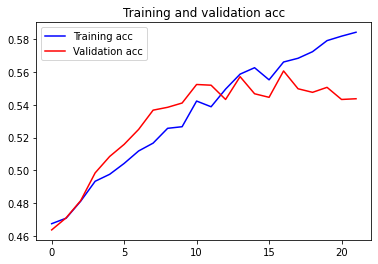

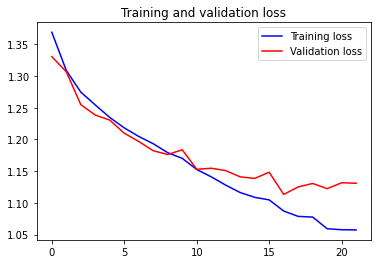

2305/2305 [==============================] - 0s 22us/sample - loss: 1.1133 - acc: 0.5605
loss:1.11
acc:0.56


In [13]:
### BEGIN SOLUTION

def runModel(model, model_name, X_train, X_test, y_train, y_test):
    plot_file = helper.plotModel(model, model_name)
    IPython.display.Image(plot_file) 

    model.summary()

    history = helper.trainModelCat( model, X_train, X_test, y_train, y_test )

    helper.plot_training(history)

    helper.eval_model(model, X_test, y_test)
    
    return history
    
embed_size_sm = 16
lstm_size_sm = 4
vocab_size_b, words_in_doc_b, embed_size_b, lstm_size_b = int(10*vocab_size), words_in_doc, int(1*embed_size_sm), lstm_size_sm
tok_b, encoded_docs_b, encoded_docs_padded_b = helper.encodeDocs(docs, vocab_size=vocab_size_b, words_in_doc=words_in_doc_b)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(encoded_docs_padded_b, sents, test_size=0.20, random_state=42)

model_x = Sequential( [Embedding(tok_b.num_words+1, embed_size_b, input_length=words_in_doc_b),
                          Dropout(0.25),
                          #LSTM(lstm_size_b), Dense(50, activation="relu"),
                          GlobalMaxPooling1D(),
                          Dropout(0.25),
                           Dense(100, activation="relu"),
                         
                          Dense( len( np.unique(y_train_b) ), activation="softmax")
                         ]
                       )

runModel(model_x, "Embedding Big + Compldex", X_train_b, X_test_b, y_train_b, y_test_b)

### END SOLUTION

## How many weights in your Classifier only model ?


**Question:** 

How many weights in your model ?
- Set a variable `num_weights` to be the number of weights 

You should always be sensitive to how "big" your model is.

In [15]:
# Set variable
num_weights = None

### BEGIN SOLUTION
num_weights = model_x.count_params()
### END SOLUTION

print('The number of weights is :', num_weights)

The number of weights is : 66221


# Submit your predictions for grading

Now that you have built your model, it's time to make predictions for grading.
- Make a prediction for each example in the file `test.csv`
- Create a file `my_submit.csv` with these predictions **in the same order** as the examples in `test.csv`
- The format of `my_submit.csv` should be similar to `submit_sample.csv`

**Hint:**

You may want  (but are not required) to use a Pandas DataFrame to create `my_submit.csv`.
- Look up the Pandas method `to_csv` in order to create a CSV file from a DataFrame
    - Use optional argument `index=False` to prevent line numbers from being inserted in your CSV file

In [17]:
# If you use Pandas DataFrame to store your results
my_results = pd.DataFrame()

### BEGIN SOLUTION
_, test = helper.getDataRaw()
docs_test = helper.getTextClean(test, textAttr)

tok_test, encoded_docs_test, encoded_docs_padded_test = helper.encodeDocs(docs_test, vocab_size=vocab_size_b, words_in_doc=words_in_doc_b)
# test_submit, _ = helper.getExamplesOHE(encoded_docs_padded_test, None, vocab_size)

my_model = model_x
# predicted_class = le.inverse_transform(np.argmax(my_model.predict(test_submit), axis=-1))
predicted_class = le.inverse_transform(np.argmax(my_model.predict(encoded_docs_padded_test), axis=-1))
my_results = pd.DataFrame({'reviewerID': test_raw['reviewerID'], 'overall':predicted_class})

### END SOLUTION

# Save your results in a csv file
my_results.to_csv('my_submit.csv', index=False)

## Discussion topics
- Compare the number of weights in each model.  Did the added complexity (more weights) lead to better performance ?
- **Where** were the largest increase in weights between models
  - Embeddings consume a lot of weights
    - But eliminates a dimension: single integer representation of a word vs a OHE vector of length words_in_vocab
    - So subsequent layers may need fewer weights compared to OHE
- Should we have formulated this as a Regression task rather than a Classification task ?
  - Is the difference in rating between 0 and 1 the same as between 3 and 4 ?
    - Perhaps there are bigger *absolute* differences in satisfaction  in lower ratings
      - i.e., Big difference between 0 and 1, smaller difference between 3 and 4